In [1]:
#imports
import numpy as np 
import math
import matplotlib.pyplot as plt 

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as functional

from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [ ]:
#Affine Coupling Class
class Affine_Coupling(nn.Module):
    def __init__(self, mask, hidden_dim):
        super(Affine_Coupling, self).__init__() #inherit from nn.Module
        self.input_dim = len(mask)
        self.hidden_dim = hidden_dim
        
        self.mask = mask #mask
        
        #scale fully connected layers
        self.scale_fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.scale_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.scale_fc3 = nn.Linear(self.hidden_dim, self.input_dim)
        
        self.scale = nn.Parameter(torch.Tensor(self.input_dim)) #learned param
        init.normal_(self.scale)
        
        #translation fully connected layers
        self.translation_fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.translation_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.translation_fc3 = nn.Linear(self.hidden_dim, self.input_dim)
    
    def compute_scale(self, x): #use mask to scale parts of x
        s = torch.clamp(s, -5.0, 5.0)
        s = torch.relu(self.scale_fc1(x * self.mask))
        s = torch.relu(self.scale_fc2(s))
        s = torch.relu(self.scale_fc3(s)) * self.scale        
        return s
    
    def compute_translation(self, x): #use mask to translate parts of x
        t = torch.relu(self.translation_fc1(x * self.mask))
        t = torch.relu(self.translation_fc2(t))
        t = self.translation_fc3(t)        
        return t
    
    def forward(self, x):
        #get scale and translation terms
        s = self.compute_scale(x)
        t = self.compute_translation(x)
        
        #compute output using Equation 5
        y = self.mask * x + (1 - self.mask) * (x * torch.exp(s) + t)
        #compute log determinant of Jacobian
        logdet = torch.sum((1 - self.mask) * s, -1)
        
        return y, logdet
    
    def inverse(self, y):
        s = self.compute_scale(y)
        t = self.compute_translation(y)

        #compute output but with inverse equation
        x = self.mask * y + (1 - self.mask) * ((y - t) * torch.exp(-s))
        #compute inverse log determinant
        logdet = torch.sum((1 - self.mask) * (-s), -1)

        return x, logdet
    

In [23]:
#RealNVP Class
class RealNVP_2D(nn.Module):
    def __init__(self, masks, hidden_dim, device):
        super(RealNVP_2D, self).__init__() #inherit from nn.Module
        self.hidden_dim = hidden_dim
        self.device = device
        #stores masks as tensors
        self.masks = nn.ParameterList([nn.Parameter(m.detach().clone().to(device), requires_grad=False) for m in masks])
        #creates affine coupling layers from masks
        self.affine_couplings = nn.ModuleList([Affine_Coupling(self.masks[i], self.hidden_dim).to(device) for i in range(len(self.masks))])
        
    def forward(self, x):
        #pass x through all coupling layers
        y = x #protects original variable
        logdet_tot = 0
        for i in range(len(self.affine_couplings)):
            y, logdet = self.affine_couplings[i](y)
            logdet_tot += logdet #sum up log determinant
            
        #restrains output to within [-4, 4]
        logdet = torch.sum(torch.log(torch.abs(4*(1-(torch.tanh(y))**2))), -1)
        y = 4*torch.tanh(y)
        logdet_tot += logdet
        
        return y, logdet_tot
    
    def inverse(self, y):
        x = y #protects original variable
        logdet_tot = 0

        #reverse normalization
        logdet = torch.sum(torch.log(torch.abs(1.0 / 4.0 * 1 / (1 - (x / 4) ** 2))), -1)
        x = 0.5 * torch.log((1 + x / 4) / (1 - x / 4))
        logdet_tot += logdet
        
        #pass y through all coupling layers in reverse order
        for i in range(len(self.affine_couplings)-1, -1, -1):
            x, logdet = self.affine_couplings[i].inverse(x)
            logdet_tot += logdet
            
        return x, logdet_tot

In [4]:
#complex 2d distributions test
from sklearn.datasets import make_moons, make_swiss_roll, make_circles, make_blobs

def sample_gaussian_mixture(n=1000, centers=8, std=0.2):
    angles = np.linspace(0, 2 * np.pi, centers, endpoint=False)
    x = np.cos(angles)
    y = np.sin(angles)
    centers = np.stack([x, y], axis=1) * 3
    data, _ = make_blobs(n_samples=n, centers=centers, cluster_std=std)
    return data

def sample_two_moons(n=1000, noise=0.05):
    data, _ = make_moons(n_samples=n, noise=noise)
    data *= 4
    return data

def sample_swiss_roll(n=1000, noise=0.25):
    data, _ = make_swiss_roll(n_samples=n, noise=noise)
    return data[:, [0, 2]] / 5

def sample_circles(n=1000, noise=0.05):
    data, _ = make_circles(n_samples=n, noise=noise, factor=0.5)
    data *= 4
    return data

def sample_spiral(n=1000, noise=0.2):
    theta = np.sqrt(np.random.rand(n)) * 2 * np.pi
    r = 2 * theta + np.pi
    x = r * np.cos(theta) + np.random.randn(n) * noise
    y = r * np.sin(theta) + np.random.randn(n) * noise
    return np.stack([x, y], axis=1) / 5

def plot_2d_data(data, title="2D Data", figsize=(5, 5)):
    if hasattr(data, "detach"):  # torch tensor
        data = data.detach().cpu().numpy()

    plt.figure(figsize=figsize)
    plt.scatter(data[:, 0], data[:, 1], s=5, alpha=0.7)
    plt.title(title)
    plt.xlim(-4, 4)
    plt.ylim(-4, 4)
    plt.gca().set_aspect('equal')
    plt.axis('off')

Step 0: loss = 16.6562
Step 500: loss = 6.0596
Step 1000: loss = 6.4451
Step 1500: loss = 6.0443
Step 2000: loss = 6.6799
Step 2500: loss = 6.9105
Step 3000: loss = 6.6690
Step 3500: loss = 6.6586
Step 4000: loss = 6.6746
Step 4500: loss = 6.5858


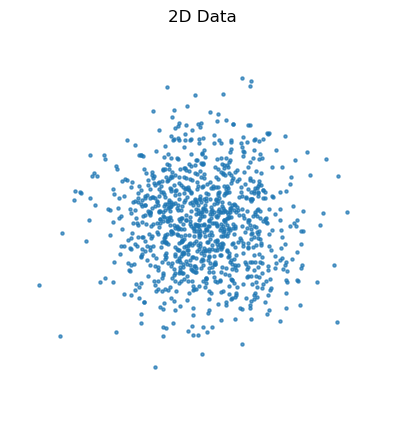

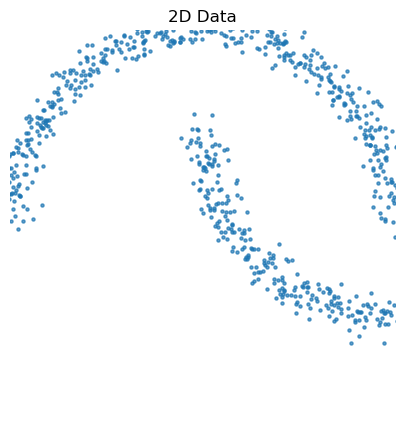

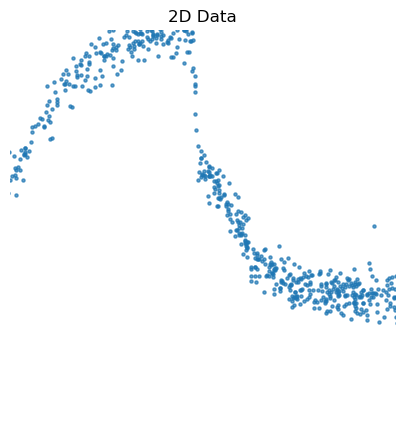

In [ ]:
moons_data = sample_two_moons()
moons = torch.tensor(moons_data, dtype=torch.float32) #tensor conversion

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
masks = [torch.tensor([1.0, 0.0]), torch.tensor([0.0, 1.0])]
model = RealNVP_2D(masks=masks, hidden_dim=64, device=device).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train(model, data, steps=5000, batch_size=512):
    model.train()
    for step in range(steps):
        idx = torch.randint(0, data.size(0), (batch_size,))
        batch = data[idx].to(model.device)

        z, logdet = model.forward(batch)
        logpz = -0.5 * torch.sum(z**2, dim=1) - z.size(1) * 0.5 * torch.log(torch.tensor(2 * torch.pi))
        loss = -(logpz + logdet).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 500 == 0:
            print(f"Step {step}: loss = {loss.item():.4f}")
            
train(model, moons)
print("Latent Space")
plot_2d_data(z.cpu())
model.eval()
with torch.no_grad():
    z = torch.randn(1000, 2).to(model.device)
    x_samples, _ = model.inverse(z)
    
print("Original Dataset")
plot_2d_data(moons)
print("Model Resulting Data")
plot_2d_data(x_samples)

In [ ]:
#Image test


100%|██████████| 170498071/170498071 [00:39<00:00, 4262855.06it/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
